In [15]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from math import *
import matplotlib.animation as animation

# 逆運動学を解いて各関節角度を出力
def calc_ik(goal_pos, l1, l2, l3):
    x_ref = goal_pos[0][0]
    y_ref = goal_pos[1][0]
    alpha = goal_pos[2][0]
    
    A = x_ref - (l3*cos(alpha))
    B = y_ref - (l3*sin(alpha))
    #print((A**2+B**2+l1**2-l2**2)/(2*l1*sqrt(A**2+B**2)))
    phi1 = atan2(B,A) + acos((A**2+B**2+l1**2-l2**2)/(2*l1*sqrt(A**2+B**2)))
    phi2 = -phi1 + atan2((B-l1*sin(phi1)),(A-l1*cos(phi1)))
    phi3 = alpha - phi1 - phi2
                    
    return phi1,phi2,phi3

# 直線軌道での所望の座標を出力 start, endはnumpy_array
def calc_line_coodinate(start, end, cur_t, req_t):
    s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
    goal_pos = start*(1-s) + end*s
    
    return goal_pos 

# 追従させる軌道 直線 端点の2つの座標を与える.  binは時間の分割数. 各時刻における所望の座標のリストを返す(indexは分割数個)
def calc_line_coodinate_bytime(start, end, req_t):
    cur_t = 0
    x_refs = []
    y_refs = []
    while(cur_t < req_t):
        s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
        x_ref = start[0]*(1-s) + end[0]*s
        y_ref = start[1]*(1-s) + end[1]*s
        x_refs.append(x_ref)
        y_refs.append(y_ref)
        cur_t += 1
    
    return x_refs, y_refs

# 順運動学で第一関節の位置を計算
def calc_cur_first_pos(l1,phi1):
    x = l1*cos(phi1)
    y = l1*sin(phi1)
    cur_first_pos = [x,y]

    return cur_first_pos

# 順運動学で第二関節の位置を計算
def calc_cur_second_pos(l1,l2,phi1,phi2):
    x = l1*cos(phi1) + l2*cos(phi1+phi2)
    y = l1*sin(phi1) + l2*sin(phi1+phi2)
    cur_second_pos = [x,y]

    return cur_second_pos

# 順運動学で現在の関節角度から手先位置を計算
def calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3):
    x = l1*cos(phi1) + l2*cos(phi1+phi2) + l3*cos(phi1+phi2+phi3)
    y = l1*sin(phi1) + l2*sin(phi1+phi2) + l3*sin(phi1+phi2+phi3)
    alpha = phi1+phi2+phi3

    cur_hand_pos = np.array([[x],
                             [y],
                             [alpha]])

    return cur_hand_pos

start
[[272.77463633]
 [110.43123409]
 [  0.5       ]]
end
[[272.77463633]
 [-69.56876591]
 [  0.        ]]


<IPython.core.display.Javascript object>


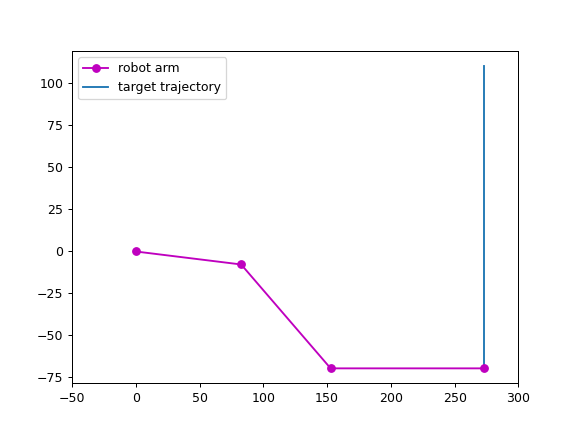

done


In [18]:
# params
phi1 = 0.2
phi2 = 0.2
phi3 = 0.1

#簡単のためとりあえず全て1
l1 = 83
l2 = 93.5
l3 = 120

# 初期位置, 終了位置
start = calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3)
end = np.array([[start[0][0]],
                [start[1][0] - 180],
                [0]]
               )

# 処理にかかる時間
req_t = 200 # ms

# 描画用
ims = []
fig = plt.figure()
flag_legend = True

# iteration
cur_t = 0
x_refs, y_refs = calc_line_coodinate_bytime(start, end, req_t)
while (cur_t < req_t):
    cur_t += 1
    goal_pos = calc_line_coodinate(start, end, cur_t, req_t)
    phi1, phi2, phi3 = calc_ik(goal_pos, l1, l2, l3)
    cur_first_pos = calc_cur_first_pos(l1,phi1)
    cur_second_pos = calc_cur_second_pos(l1,l2,phi1,phi2)
    cur_hand_pos = calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3)
    
    # プロット用
    im1 = plt.plot([0,cur_first_pos[0],cur_second_pos[0],cur_hand_pos[0][0]],[0,cur_first_pos[1],cur_second_pos[1],cur_hand_pos[1][0]],'b-o',label="robot arm",color="m")
    ims.append(im1+im2)
    
    if flag_legend: # 1回のみ凡例を描画
        plt.plot(x_refs, y_refs, label="target trajectory")
        plt.legend()
        plt.xlim(-50,300)
        flag_legend = False

ani = animation.ArtistAnimation(fig, ims, interval=10)
ani.save('time_line_compiance_3link.gif', writer='pillow', fps=50)
fig.show()
print("done")